# Initialize the Environment

In [1]:
try:
    %load_ext autoreload
    %autoreload 2
    
except:
    print 'NOT IPYTHON'

from __future__ import division
from IPython.display import display

import os
#os.environ['MKL_NUM_THREADS'] = '1'
import sys
import glob
import json
import subprocess
from multiprocessing import Pool

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as io
import scipy.sparse as sp
from sklearn import manifold
import h5py

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams


import fig_plotting
rcParams = fig_plotting.update_rcparams(rcParams)

import scipy.stats as stats

os.chdir('../')
import Codebase
conv_adj_matr_to_cfg_matr = Codebase.Networks.configuration.convert_adj_matr_to_cfg_matr
conv_cfg_vec_to_adj_matr = Codebase.Networks.configuration.convert_conn_vec_to_adj_matr
from Codebase.Networks.SubgraphDetection.nonnegfac import nmf
os.chdir('./Analysis_Notebooks/')

path_MetaData = '/home1/a/ankk/LittHome/Remotes/CORE.ieeg_ltm.multiinst/Raw_Neocortical'
path_CoreData = '/home1/a/ankk/LittHome/Remotes/CORE.ieeg_ltm.multiinst/Dyne_Neocortical/FuncConn.XCorr_WideBand.0_115/network'
path_PeriphData = '/home1/a/ankk/LittHome/Remotes/RSRCH.InterictalSubgraph'
path_InpData_Cons = path_PeriphData + '/ds-e03-NMF_Consensus.FC_0_115_Hz'
path_InpData_Cocl = path_PeriphData + '/ds-e04-NMF_CoCluster.FC_0_115_Hz'
path_ExpData = path_PeriphData + '/ds-e05-Subgraph_State_Stats.FC_0_115_Hz'

for path in [path_CoreData, path_PeriphData, path_ExpData]:
    if not os.path.exists(path):
        print('Path: {}, does not exist'.format(path))
        os.makedirs(path)

Path: /home1/a/ankk/LittHome/Remotes/RSRCH.InterictalSubgraph/ds-e05-Subgraph_State_Stats.FC_0_115_Hz, does not exist


/home1/a/ankk/Developer/miniconda2/envs/cb-resection/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Generate Data List

In [2]:
# Get clinical_metadata
df_meta = h5py.File('{}/clinical_metadata.mat'.format(path_MetaData), 'r')
meta_subj = [''.join(unichr(c) for c in df_meta[r])
             for r in df_meta['subject']['ID'][:, 0]]

subj_dict = {}
for subj_id in meta_subj:        
    
    # Get the block and cluster assignments
    try:
        block_epoch = np.load('{}/NMF_Subgraph_Ensemble.{}.npz'.format(path_InpData_Cocl, subj_id))['block_ensemble_matr']
        block_epoch_null = np.load('{}/NMF_Subgraph_Ensemble.NULL.{}.npz'.format(path_InpData_Cocl, subj_id))['block_ensemble_matr']
        
        clust = np.load('{}/NMF_Subgraph_States.{}.npz'.format(path_InpData_Cocl, subj_id))['states']
        clust_null = np.load('{}/NMF_Subgraph_States.NULL.{}.npz'.format(path_InpData_Cocl, subj_id))['states']
        
        block_locs = np.load('{}/NMF_Subgraph_Projection.{}.npz'.format(path_InpData_Cocl, subj_id))['block_locs']        
        block_locs_null = np.load('{}/NMF_Subgraph_Projection.NULL.{}.npz'.format(path_InpData_Cocl, subj_id))['block_locs']        
    except IOError:
        continue
        
    subj_dict[subj_id] = {}
    subj_dict[subj_id]['Real_Cluster'] = {}
    subj_dict[subj_id]['Null_Cluster'] = {}    
        
    subj_dict[subj_id]['Real_Cluster']['epoch_lbl'] = np.array([epoch_str.split('.')[1] for epoch_str in block_epoch])
    subj_dict[subj_id]['Null_Cluster']['epoch_lbl'] = np.array([epoch_str.split('.')[1] for epoch_str in block_epoch_null])

    subj_dict[subj_id]['Real_Cluster']['epoch_id'] = np.unique(subj_dict[subj_id]['Real_Cluster']['epoch_lbl'])  
    subj_dict[subj_id]['Null_Cluster']['epoch_id'] = np.unique(subj_dict[subj_id]['Null_Cluster']['epoch_lbl'])
    
    subj_dict[subj_id]['Real_Cluster']['clust_lbl'] = clust
    subj_dict[subj_id]['Null_Cluster']['clust_lbl'] = clust_null

    subj_dict[subj_id]['Real_Cluster']['clust_id'] = np.unique(clust)
    subj_dict[subj_id]['Null_Cluster']['clust_id'] = np.unique(clust_null)
    
    subj_dict[subj_id]['Real_Cluster']['n_clust'] = len(subj_dict[subj_id]['Real_Cluster']['clust_id'])
    subj_dict[subj_id]['Null_Cluster']['n_clust'] = len(subj_dict[subj_id]['Null_Cluster']['clust_id'])    
        
    subj_dict[subj_id]['Real_Cluster']['projection'] = block_locs
    subj_dict[subj_id]['Null_Cluster']['projection'] = block_locs_null  

n_subj = len(subj_dict.keys())
subj_key = np.sort(subj_dict.keys())    

# Number of Clusters

/home1/a/ankk/Developer/miniconda2/envs/cb-resection/lib/python2.7/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))
/home1/a/ankk/Developer/miniconda2/envs/cb-resection/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


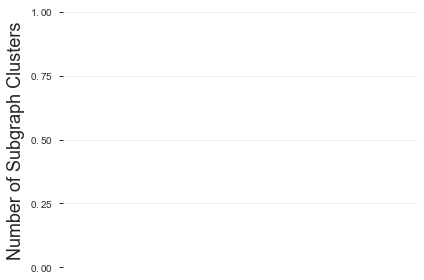

In [3]:
%matplotlib inline

plt.figure()
ax = plt.subplot(111)

for ii, subj_id in enumerate(subj_key):
    ax.bar(ii, subj_dict[subj_id]['Real_Cluster']['n_clust'])

ax.set_xlim([0, n_subj])    
plt.xticks(np.linspace(0.5, n_subj-0.5, n_subj),
           subj_key,
           rotation=60)
ax.xaxis.set_ticks_position('bottom')


ticks = ax.get_yticks()
ax.set_yticks(np.linspace(ticks[0], ticks[-1], 5))
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('Number of Subgraph Clusters')

plt.savefig('./e05-Figures/Num_Subgraph_Clusters.svg')

# Subgraph Projection

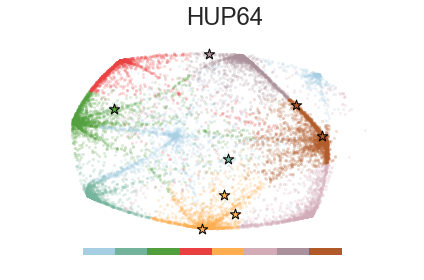

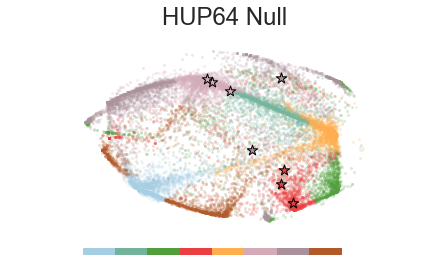

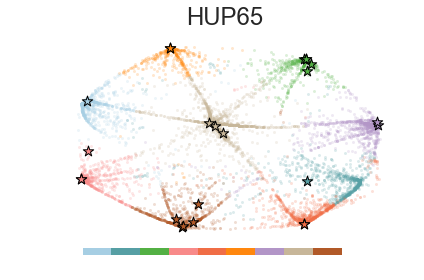

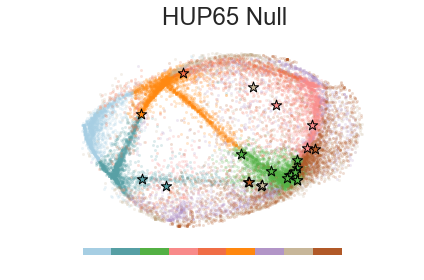

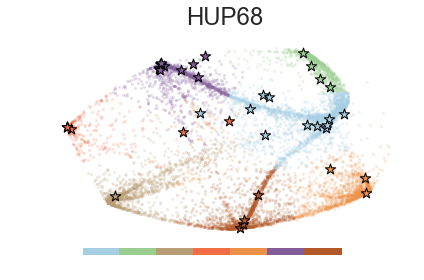

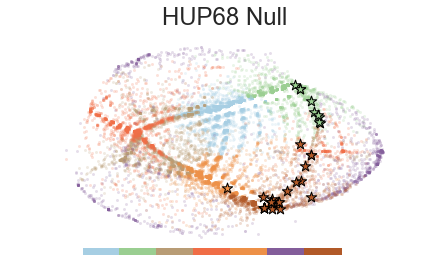

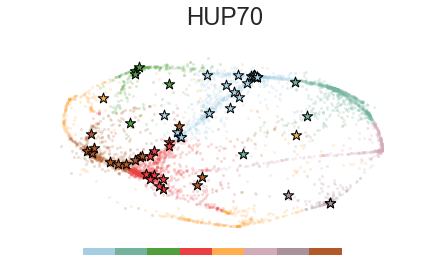

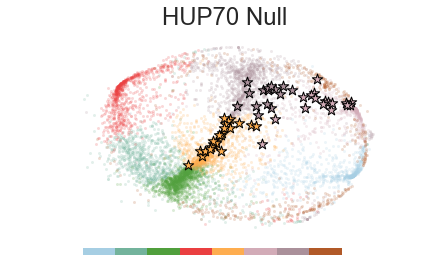

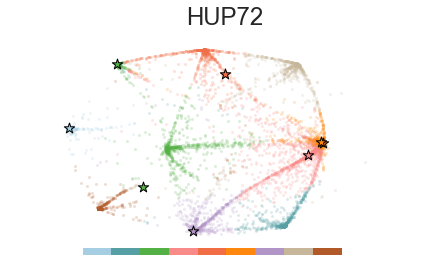

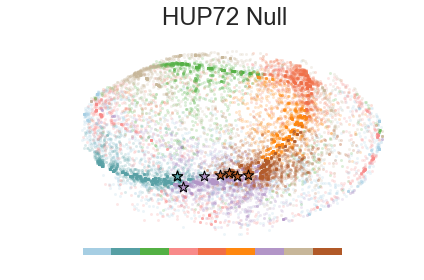

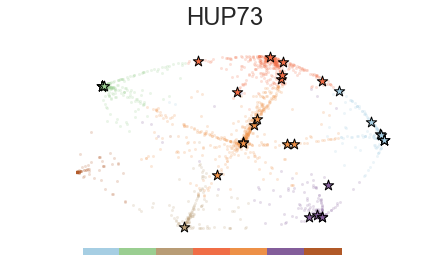

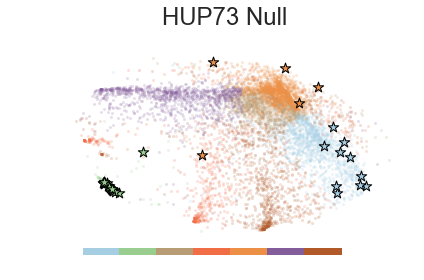

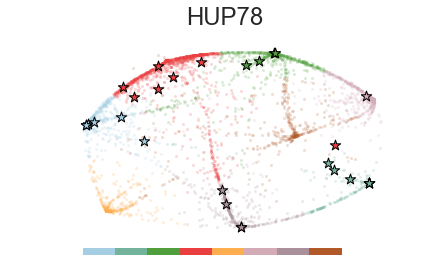

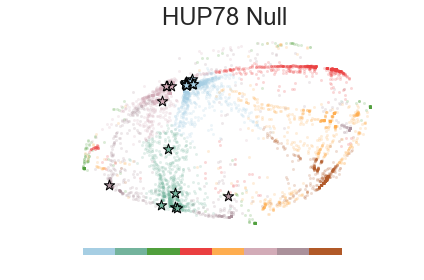

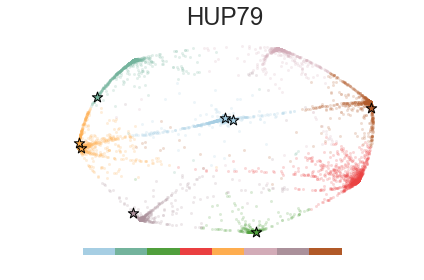

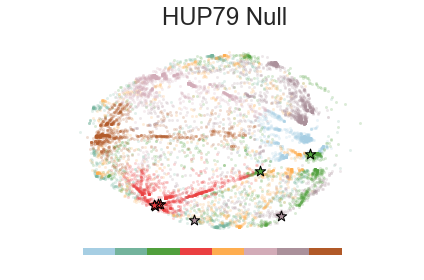

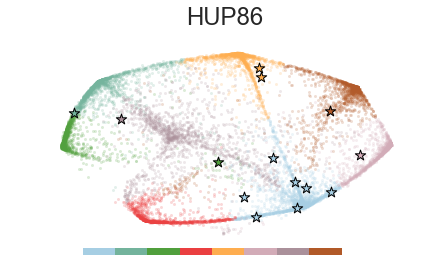

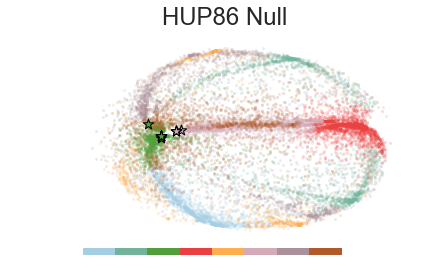

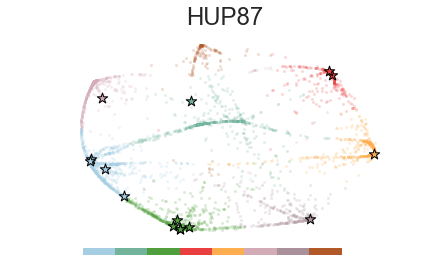

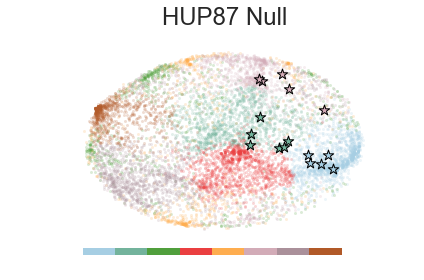

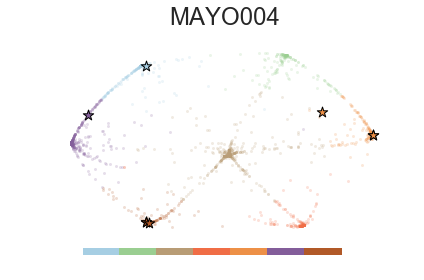

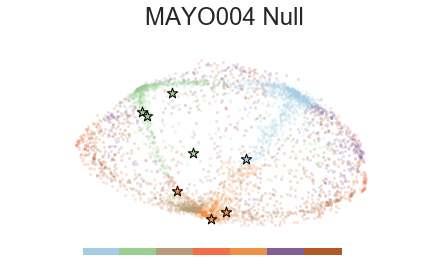

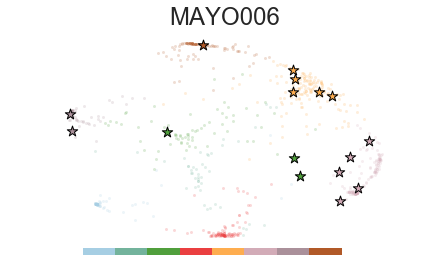

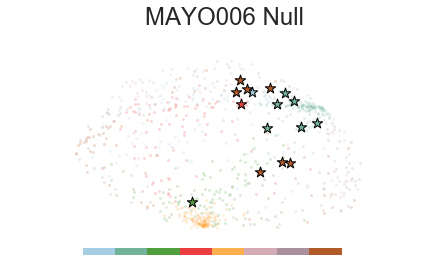

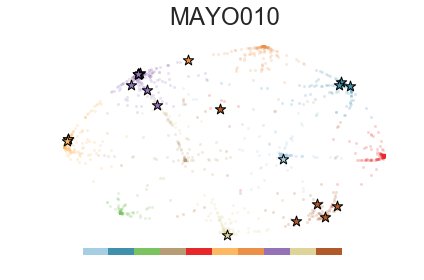

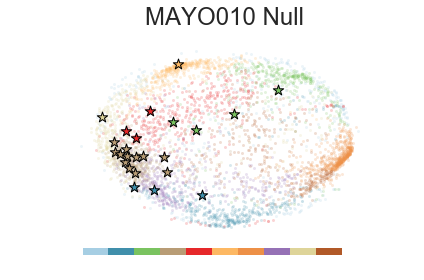

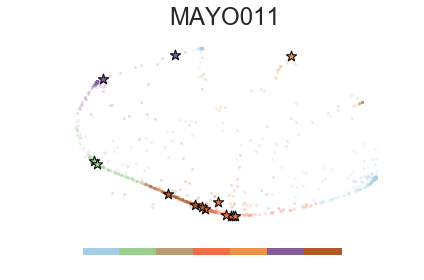

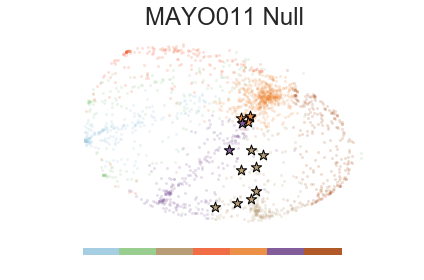

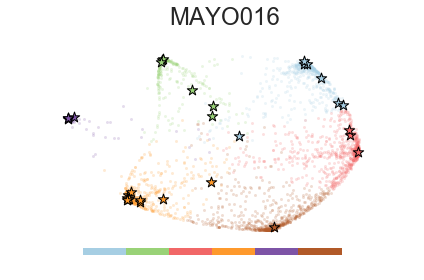

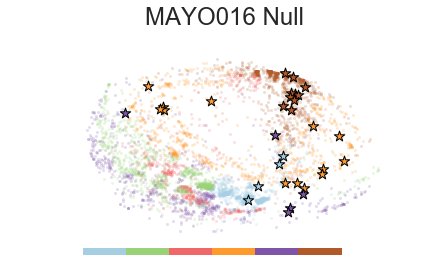

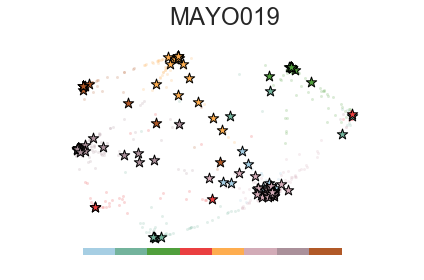

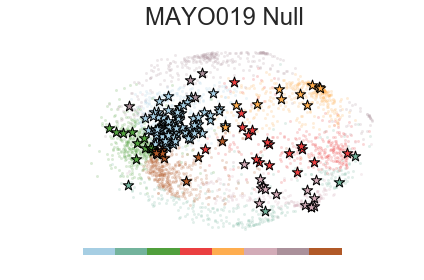

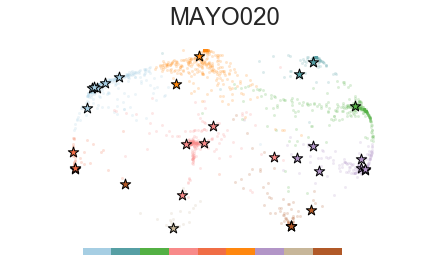

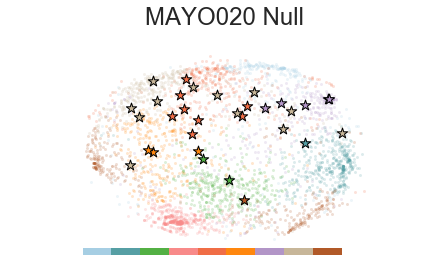

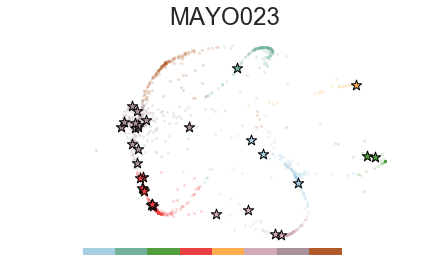

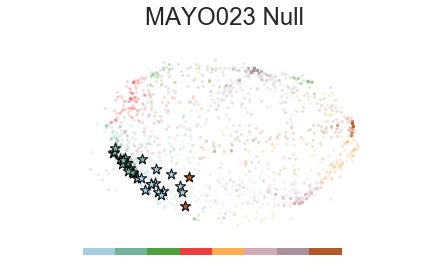

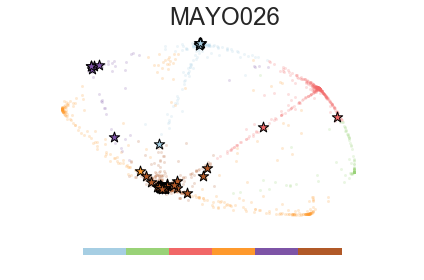

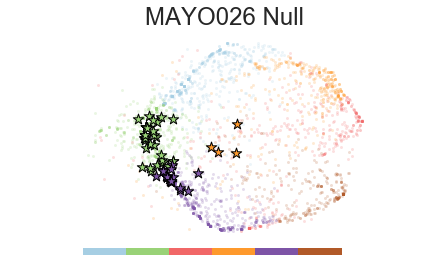

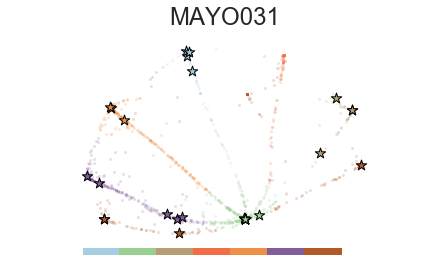

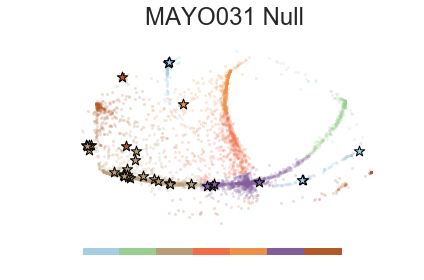

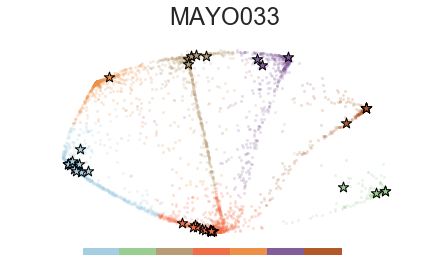

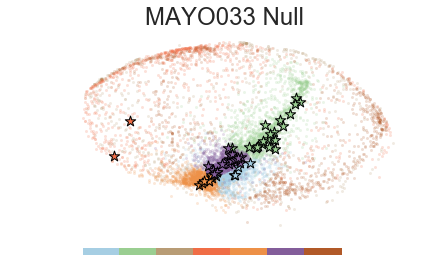

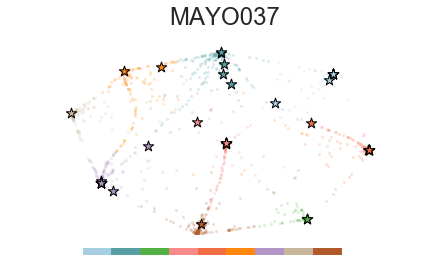

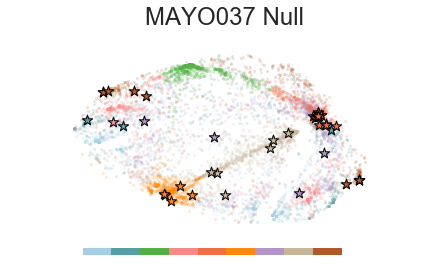

In [6]:
%matplotlib inline

for ii, subj_id in enumerate(subj_key):

    # Handle Colormap
    cmap = plt.cm.get_cmap('Paired')
    cmaplist = [cmap(i) for i in range(cmap.N)]
    #cmaplist = cmaplist[10:-10]

    cmap = cmap.from_list('Custom', cmaplist, subj_dict[subj_id]['Real_Cluster']['n_clust'])
    bounds = np.linspace(0, subj_dict[subj_id]['Real_Cluster']['n_clust'], 
                         subj_dict[subj_id]['Real_Cluster']['n_clust']+1)
    cnorm = mpl.colors.BoundaryNorm(bounds, cmap.N)    
    clr_in = cmap(np.arange(subj_dict[subj_id]['Real_Cluster']['n_clust']))
    
    # Handle epoch-specific plotting params
    marker = {'interictal': '.',
              'preictal': '.',
              'ictal': '*'}
    m_size = {'interictal': 36,
               'preictal': 120,
               'ictal': 120}    
    alpha = {'interictal': 0.2,
              'preictal': 1.0,
              'ictal': 1.0}
    clr_out = {'interictal': 0.0,
               'preictal': 1.0,
               'ictal': 1.0}
    
    # Plot the Real Subgraph Space
    fig = plt.figure()
    ax = plt.subplot(111)
    for ep_id in ['interictal', 'ictal']:
        ep_ix = np.flatnonzero(subj_dict[subj_id]['Real_Cluster']['epoch_lbl'] == ep_id)
        
        for cl_id in subj_dict[subj_id]['Real_Cluster']['clust_id']:
            cl_ix = np.flatnonzero(subj_dict[subj_id]['Real_Cluster']['clust_lbl'] == cl_id)
            
            pt_ix = np.intersect1d(ep_ix, cl_ix)
            ax.scatter(subj_dict[subj_id]['Real_Cluster']['projection'][pt_ix, 0],
                       subj_dict[subj_id]['Real_Cluster']['projection'][pt_ix, 1],
                       s=m_size[ep_id], marker=marker[ep_id], lw=clr_out[ep_id],
                       edgecolors='k', color=clr_in[cl_id, :], 
                       alpha=alpha[ep_id])
    ax.set_axis_off()
    ax.set_title(subj_id)

    # Add a colorbar
    ax_cb = fig.add_axes([0.20, 0.1, 0.6, 0.025])
    mpl.colorbar.ColorbarBase(ax_cb, cmap=cmap, norm=cnorm,
                                spacing='proportional',
                                boundaries=bounds,
                                orientation='horizontal',
                                ticks=[])
    
    plt.savefig('./e05-Figures/Subgraph_Projection.{}.svg'.format(subj_id))    
    
    
    
    # Plot the Real Subgraph Space    
    fig = plt.figure()    
    ax = plt.subplot(111)
    for ep_id in ['interictal', 'ictal']:
        ep_ix = np.flatnonzero(subj_dict[subj_id]['Null_Cluster']['epoch_lbl'] == ep_id)
        
        for cl_id in subj_dict[subj_id]['Null_Cluster']['clust_id']:
            cl_ix = np.flatnonzero(subj_dict[subj_id]['Null_Cluster']['clust_lbl'] == cl_id)
            
            pt_ix = np.intersect1d(ep_ix, cl_ix)
            ax.scatter(subj_dict[subj_id]['Null_Cluster']['projection'][pt_ix, 0],
                       subj_dict[subj_id]['Null_Cluster']['projection'][pt_ix, 1],
                       s=m_size[ep_id], marker=marker[ep_id], lw=clr_out[ep_id],
                       edgecolors='k', color=clr_in[cl_id, :], 
                       alpha=alpha[ep_id])
    ax.set_axis_off()
    ax.set_title(subj_id + ' Null')
    
    # Add a colorbar
    ax_cb = fig.add_axes([0.20, 0.1, 0.6, 0.025])
    mpl.colorbar.ColorbarBase(ax_cb, cmap=cmap, norm=cnorm,
                                spacing='proportional',
                                boundaries=bounds,
                                orientation='horizontal',
                                ticks=[])

    plt.savefig('./e05-Figures/Subgraph_Projection.NULL.{}.svg'.format(subj_id))

    plt.show()

# Normalized Projection Distance to Cluster Centroid

In [13]:
def norm_proj_dist_to_centroid(pop_centroid_pos, cluster_centroid_pos, sample_pos):
    
    dist_to_centroid = \
        np.sqrt((cluster_centroid_pos[0]-sample_pos[0])**2 + \
                (cluster_centroid_pos[1]-sample_pos[1])**2)
    dist_to_pop = \
        np.sqrt((pop_centroid_pos[0]-sample_pos[0])**2 + \
                (pop_centroid_pos[1]-sample_pos[1])**2)

    #return dist_to_centroid / dist_to_pop 
    return (dist_to_centroid - dist_to_pop) / (dist_to_pop + dist_to_centroid)

data_table = {'Subject': [],
              'D2C': [],
              'Epoch': [],
              'Model': []}

for subj_ii, subj_id in enumerate(subj_key):

    for model_id in ['Real_Cluster', 'Null_Cluster']:
        # Compute population centroid position
        pop_centroid_pos = np.mean(subj_dict[subj_id][model_id]['projection'], axis=0)
    
        # Compute cluster centroid position
        cluster_centroid_pos = {}
        for cl_id in subj_dict[subj_id][model_id]['clust_id']:
            cl_ix = np.flatnonzero(subj_dict[subj_id][model_id]['clust_lbl'] == cl_id)
            cluster_centroid_pos[cl_id] = np.mean(subj_dict[subj_id][model_id]['projection'][cl_ix, :], axis=0)
        
        # Find epoch type
        for epoch_id in ['ictal', 'interictal']:
            ep_ix = np.flatnonzero(subj_dict[subj_id][model_id]['epoch_lbl'] == epoch_id)
        
            for pt_ix in ep_ix:

                # Cluster ID for the sample
                cl_id = subj_dict[subj_id][model_id]['clust_lbl'][pt_ix]

                # Normalize projection distance to cluster centroid for sample
                sample_pos = subj_dict[subj_id][model_id]['projection'][pt_ix, :]
                
                norm_dist = norm_proj_dist_to_centroid(pop_centroid_pos,
                                                       cluster_centroid_pos[cl_id],
                                                       sample_pos)

                data_table['Subject'].append(subj_id)
                data_table['D2C'].append(norm_dist)
                data_table['Epoch'].append(epoch_id)
                data_table['Model'].append(model_id)

# Save Data Table for R-stats
df = pd.DataFrame(data_table, columns=data_table.keys())
df.to_csv('./e05-R_Stats/subgraph_integration.csv')

# Cluster Cohesion

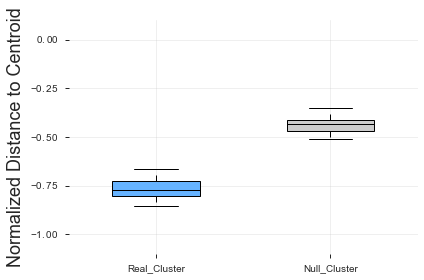

In [26]:
df = pd.read_csv('./e05-R_Stats/subgraph_integration.csv')

# Plot the data frame
%matplotlib inline
color = {'Null_Cluster': [0.8, 0.8, 0.8],
         'Real_Cluster': [0.4, 0.7, 1]}

plt.figure()
ax = plt.subplot(111)

model_lbl = []
for model_ii, model_id in enumerate(['Real_Cluster', 'Null_Cluster']):
    sel_model = df[df['Model'] == model_id]
    sel_res = sel_model['D2C'].groupby(df['Subject']).mean()

    bplot = ax.boxplot([sel_res], positions=[model_ii],
               widths=[0.5], whis=[5, 95], patch_artist=True)
    fig_plotting.set_box_color(bplot, 'k', [color[model_id]])
    
    model_lbl.append(model_id)
    
ax.set_xlim([-0.5, 1.5])        
plt.xticks([0, 1],
           model_lbl)
ax.xaxis.set_ticks_position('bottom')

ax.set_ylim([-1.1, 0.1])        
ax.set_yticks(np.linspace(-1.0, 0.0, 5))
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('Normalized Distance to Centroid')

plt.savefig('./e05-Figures/Subgraph_Integration.svg')
plt.show()

# Ictal/Interictal Cohesion

/mnt/castor/seas_home/a/ankk/Developer/miniconda2/envs/cb-resection/lib/python2.7/site-packages/ipykernel/__main__.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


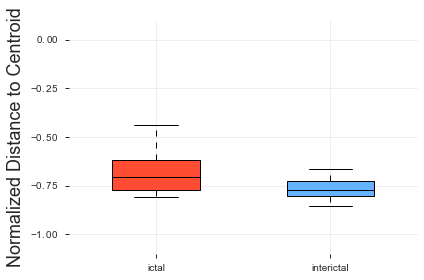

In [29]:
df = pd.read_csv('./e05-R_Stats/subgraph_integration.csv')

# Plot the data frame
%matplotlib inline
color = {'interictal': [0.4, 0.7, 1],
         'ictal': [1.0, 0.3, 0.2]}

plt.figure()
ax = plt.subplot(111)

sel_model = df[df['Model'] == 'Real_Cluster']
epoch_lbl = []
for epoch_ii, epoch_id in enumerate(['ictal', 'interictal']):
    sel_epoch = sel_model[df['Epoch'] == epoch_id]
    sel_res = sel_epoch['D2C'].groupby(df['Subject']).mean()

    bplot = ax.boxplot([sel_res], positions=[epoch_ii],
               widths=[0.5], whis=[5, 95], patch_artist=True)
    fig_plotting.set_box_color(bplot, 'k', [color[epoch_id]])
    
    epoch_lbl.append(epoch_id)
    
ax.set_xlim([-0.5, 1.5])        
plt.xticks([0, 1],
           epoch_lbl)
ax.xaxis.set_ticks_position('bottom')

ax.set_ylim([-1.1, 0.1])        
ax.set_yticks(np.linspace(-1.0, 0.0, 5))
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('Normalized Distance to Centroid')

plt.savefig('./e05-Figures/Ictal_Integration.svg')
plt.show()